### Importing libraries

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn import metrics
import calendar
import xgboost as xgb

#### Loading data

In [29]:
train_data = pd.read_csv('train_data_iitm.csv')
test_data = pd.read_csv('test_data_iitm.csv')
taxi_mapping = pd.read_csv('taxi_zone_mapping.csv')


### Analysing data

In [30]:
train_data.shape

(60000, 12)

In [31]:
train_data.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,congestion_surcharge
0,2.0,2020-06-10 13:36:49,2020-06-10 13:51:08,1.0,2.73,1.0,N,224,148,2.0,12.00,2.5
1,NaN,2020-06-13 06:19:00,2020-06-13 06:37:00,NaN,11.58,NaN,NaN,56,42,NaN,28.81,0.0
2,2.0,2020-06-20 07:59:23,2020-06-20 08:05:39,1.0,2.05,1.0,N,79,68,2.0,8.00,2.5
3,1.0,2020-06-27 15:11:32,2020-06-27 15:15:02,1.0,1.40,1.0,N,236,75,1.0,6.00,2.5
4,1.0,2020-06-26 16:00:36,2020-06-26 16:02:28,1.0,0.60,1.0,N,186,90,2.0,4.00,2.5


In [32]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   VendorID               54365 non-null  float64
 1   tpep_pickup_datetime   60000 non-null  object 
 2   tpep_dropoff_datetime  60000 non-null  object 
 3   passenger_count        54365 non-null  float64
 4   trip_distance          60000 non-null  float64
 5   RatecodeID             54365 non-null  float64
 6   store_and_fwd_flag     54365 non-null  object 
 7   PULocationID           60000 non-null  int64  
 8   DOLocationID           60000 non-null  int64  
 9   payment_type           54365 non-null  float64
 10  fare_amount            60000 non-null  float64
 11  congestion_surcharge   60000 non-null  float64
dtypes: float64(7), int64(2), object(3)
memory usage: 5.5+ MB


In [33]:
train_data.isnull().sum().sort_index()/len(train_data)

DOLocationID             0.000000
PULocationID             0.000000
RatecodeID               0.093917
VendorID                 0.093917
congestion_surcharge     0.000000
fare_amount              0.000000
passenger_count          0.093917
payment_type             0.093917
store_and_fwd_flag       0.093917
tpep_dropoff_datetime    0.000000
tpep_pickup_datetime     0.000000
trip_distance            0.000000
dtype: float64

In [34]:
train_data.describe()

,VendorID,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,congestion_surcharge
count,54365.000000,54365.000000,60000.000000,54365.000000,60000.000000,60000.000000,54365.000000,60000.000000,60000.000000
mean,1.597554,1.353702,3.368568,1.047383,157.733683,153.572183,1.373604,13.626738,1.965417
std,0.490395,1.012809,4.323149,1.078021,69.510520,73.940982,0.532802,13.454365,1.048347
min,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,-149.000000,-2.500000
25%,1.000000,1.000000,1.010000,1.000000,107.000000,87.000000,1.000000,6.000000,2.500000
50%,2.000000,1.000000,1.850000,1.000000,151.000000,151.000000,1.000000,9.000000,2.500000
75%,2.000000,1.000000,3.670000,1.000000,234.000000,233.000000,2.000000,15.500000,2.500000
max,2.000000,6.000000,114.300000,99.000000,265.000000,265.000000,5.000000,400.000000,2.500000


In [35]:
train_data['tpep_pickup_datetime']=pd.to_datetime(train_data['tpep_pickup_datetime'],format='%Y-%m-%d %H:%M:%S')
train_data['tpep_dropoff_datetime']=pd.to_datetime(train_data['tpep_dropoff_datetime'],format='%Y-%m-%d %H:%M:%S')
train_data['pickup_date']= train_data['tpep_pickup_datetime'].dt.date
train_data['pickup_day']=train_data['tpep_pickup_datetime'].apply(lambda x:x.day)
train_data['pickup_hour']=train_data['tpep_pickup_datetime'].apply(lambda x:x.hour)
train_data['pickup_day_of_week']=train_data['tpep_pickup_datetime'].apply(lambda x:calendar.day_name[x.weekday()])
train_data['pickup_month']=train_data['tpep_pickup_datetime'].apply(lambda x:x.month)
train_data['pickup_year']=train_data['tpep_pickup_datetime'].apply(lambda x:x.year)
train_data['time'] = (train_data.tpep_dropoff_datetime - train_data.tpep_pickup_datetime) / pd.Timedelta(minutes=1)
# train_data['time'] = train_data['time'].seconds /60.0
train_data.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,congestion_surcharge,pickup_date,pickup_day,pickup_hour,pickup_day_of_week,pickup_month,pickup_year,time
0,2.0,2020-06-10 13:36:49,2020-06-10 13:51:08,1.0,2.73,1.0,N,224,148,2.0,12.00,2.5,2020-06-10,10,13,Wednesday,6,2020,14.316667
1,NaN,2020-06-13 06:19:00,2020-06-13 06:37:00,NaN,11.58,NaN,NaN,56,42,NaN,28.81,0.0,2020-06-13,13,6,Saturday,6,2020,18.000000
2,2.0,2020-06-20 07:59:23,2020-06-20 08:05:39,1.0,2.05,1.0,N,79,68,2.0,8.00,2.5,2020-06-20,20,7,Saturday,6,2020,6.266667
3,1.0,2020-06-27 15:11:32,2020-06-27 15:15:02,1.0,1.40,1.0,N,236,75,1.0,6.00,2.5,2020-06-27,27,15,Saturday,6,2020,3.500000
4,1.0,2020-06-26 16:00:36,2020-06-26 16:02:28,1.0,0.60,1.0,N,186,90,2.0,4.00,2.5,2020-06-26,26,16,Friday,6,2020,1.866667


In [36]:
train_data.describe()

,VendorID,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,congestion_surcharge,pickup_day,pickup_hour,pickup_month,pickup_year,time
count,54365.000000,54365.000000,60000.000000,54365.000000,60000.000000,60000.000000,54365.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000
mean,1.597554,1.353702,3.368568,1.047383,157.733683,153.572183,1.373604,13.626738,1.965417,16.851517,13.267533,5.999917,2019.999817,14.434429
std,0.490395,1.012809,4.323149,1.078021,69.510520,73.940982,0.532802,13.454365,1.048347,8.624959,5.155583,0.021213,0.044907,54.184699
min,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,-149.000000,-2.500000,1.000000,0.000000,1.000000,2009.000000,0.000000
25%,1.000000,1.000000,1.010000,1.000000,107.000000,87.000000,1.000000,6.000000,2.500000,10.000000,10.000000,6.000000,2020.000000,5.566667
50%,2.000000,1.000000,1.850000,1.000000,151.000000,151.000000,1.000000,9.000000,2.500000,18.000000,14.000000,6.000000,2020.000000,9.400000
75%,2.000000,1.000000,3.670000,1.000000,234.000000,233.000000,2.000000,15.500000,2.500000,24.000000,17.000000,6.000000,2020.000000,15.933333
max,2.000000,6.000000,114.300000,99.000000,265.000000,265.000000,5.000000,400.000000,2.500000,31.000000,23.000000,7.000000,2020.000000,1531.233333


In [37]:
print(train_data['pickup_year'].value_counts())

2020    59999
2009        1
Name: pickup_year, dtype: int64


In [38]:
print(train_data['pickup_month'].value_counts())

6    59997
7        1
5        1
1        1
Name: pickup_month, dtype: int64


In [39]:
train_data = train_data.dropna()
train_data =  train_data.drop(['tpep_pickup_datetime','tpep_dropoff_datetime','VendorID', 'pickup_month' , 'pickup_year','pickup_day','payment_type','pickup_date'],axis = 1)
train_data.replace({'store_and_fwd_flag':{"N":0,"Y":1}}, inplace=True )
train_data.replace({'pickup_day_of_week':{"Sunday":0,"Monday":1,"Tuesday":2,"Wednesday":3,"Thursday":4,"Friday":5,"Saturday":6}}, inplace=True )
train_data['day_of_week_sin'] = np.sin(train_data['pickup_day_of_week'] * (2 * np.pi / 7))
train_data['day_of_week_cos'] = np.cos(train_data['pickup_day_of_week'] * (2 * np.pi / 7))
train_data.pop('pickup_day_of_week')
train_data.head()
y = train_data['fare_amount']
X = train_data.drop(['fare_amount'],axis=1)

### Test Data Processing

In [40]:

test_data['tpep_pickup_datetime']=pd.to_datetime(test_data['tpep_pickup_datetime'],format='%Y-%m-%d %H:%M:%S')
test_data['tpep_dropoff_datetime']=pd.to_datetime(test_data['tpep_dropoff_datetime'],format='%Y-%m-%d %H:%M:%S')
test_data['pickup_hour']=test_data['tpep_pickup_datetime'].apply(lambda x:x.hour)
test_data['pickup_day_of_week']=test_data['tpep_pickup_datetime'].apply(lambda x:calendar.day_name[x.weekday()])
test_data['time'] = (test_data.tpep_dropoff_datetime - test_data.tpep_pickup_datetime) / pd.Timedelta(minutes=1)
test_data =  test_data.drop(['tpep_pickup_datetime','tpep_dropoff_datetime','VendorID','payment_type'],axis = 1)
test_data.replace({'store_and_fwd_flag':{"N":0,"Y":1}}, inplace=True )
test_data.replace({'pickup_day_of_week':{"Sunday":0,"Monday":1,"Tuesday":2,"Wednesday":3,"Thursday":4,"Friday":5,"Saturday":6}}, inplace=True )
test_data['day_of_week_sin'] = np.sin(test_data['pickup_day_of_week'] * (2 * np.pi / 7))
test_data['day_of_week_cos'] = np.cos(test_data['pickup_day_of_week'] * (2 * np.pi / 7))
test_data.pop('pickup_day_of_week')

test_data.head()

,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,congestion_surcharge,pickup_hour,time,day_of_week_sin,day_of_week_cos
0,1.0,1.66,1.0,0.0,48,90,2.5,18,5.683333,0.974928,-0.222521
1,3.0,1.50,1.0,0.0,48,246,2.5,23,7.000000,-0.781831,0.623490
2,1.0,1.90,1.0,0.0,237,234,2.5,12,7.166667,0.974928,-0.222521
3,1.0,0.27,1.0,0.0,170,170,2.5,9,2.550000,-0.781831,0.623490
4,2.0,4.06,1.0,0.0,186,238,2.5,18,16.800000,0.974928,-0.222521


#### Splitting Data into training and validation set

In [41]:
X_train, X_valid, Y_train, Y_valid = train_test_split(X,y,test_size = 0.2, random_state = 0)

### Lasso Regression

In [42]:
las_reg_model = Lasso()
las_reg_model.fit(X_train,Y_train)

Lasso()

In [43]:
prediction = las_reg_model.predict(X_train)
prediction2 = las_reg_model.predict(X_valid)

In [44]:
r2score_train = metrics.r2_score(prediction,Y_train)
print(f"R2 Score: {r2score_train}")

r2score_validation = metrics.r2_score(prediction2,Y_valid)
print(f"R2 Score: {r2score_validation}")

R2 Score: 0.5580244776112042
R2 Score: 0.6681415810999065


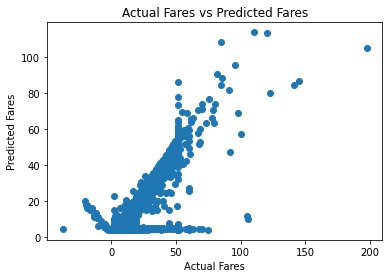

In [45]:
plt.scatter(Y_valid,prediction2)
plt.xlabel("Actual Fares")
plt.ylabel("Predicted Fares")
plt.title("Actual Fares vs Predicted Fares")
plt.show()

#### Therefore we see a need to change the model and we use XGBoost


### XGBoost

In [46]:
dtrain = xgb.DMatrix(X_train, label=Y_train)
dvalid = xgb.DMatrix(X_valid, label=Y_valid)
dtest = xgb.DMatrix(test_data)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

xgb_params = {
    'min_child_weight': 1, 
    'learning_rate': 0.05, 
    'colsample_bytree': 0.7, 
    'max_depth': 10,
    'subsample': 0.7,
    'n_estimators': 5000,
    'n_jobs': -1, 
    'booster' : 'gbtree', 
    'silent': 1,
    'eval_metric': 'rmse'}

model = xgb.train(xgb_params, dtrain, 1000, watchlist, early_stopping_rounds=100, maximize=False, verbose_eval=50)

[20:02:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimators", "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:15.57251	valid-rmse:14.78178
[50]	train-rmse:2.86451	valid-rmse:3.17284
[100]	train-rmse:1.54796	valid-rmse:2.82617
[150]	train-rmse:1.17774	valid-rmse:2.85627
[191]	train-rmse:1.03756	valid-rmse:2.85886


###  Prediction on test set

In [47]:
preds = model.predict(dtest)
test_data['fare_amount'] = preds 
test_data.head()

,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,congestion_surcharge,pickup_hour,time,day_of_week_sin,day_of_week_cos,fare_amount
0,1.0,1.66,1.0,0.0,48,90,2.5,18,5.683333,0.974928,-0.222521,6.976223
1,3.0,1.50,1.0,0.0,48,246,2.5,23,7.000000,-0.781831,0.623490,7.067053
2,1.0,1.90,1.0,0.0,237,234,2.5,12,7.166667,0.974928,-0.222521,8.010774
3,1.0,0.27,1.0,0.0,170,170,2.5,9,2.550000,-0.781831,0.623490,3.749269
4,2.0,4.06,1.0,0.0,186,238,2.5,18,16.800000,0.974928,-0.222521,15.473547


### r2 score in Validation set

In [57]:
preds2 = model.predict(dvalid)
XGB_valid = metrics.r2_score(preds2,Y_valid)
XGB_valid_error = metrics.mean_squared_error(preds2,Y_valid)
print(metrics.r2_score(preds2,Y_valid))
print(f"We get {XGB_valid * 100:0.2f}% r2scorer on Validation set for XGBoost")
print(f"We get {XGB_valid_error} mean squared error on Validation set for XGBoost")

0.9208621898888323
We get 92.09% r2scorer on Validation set for XGBoost
We get 8.15996246886413 mean squared error on Validation set for XGBoost


In [49]:
preds_train = model.predict(dtrain)
XGB_train = metrics.mean_squared_error(preds_train,Y_train)
print("We get {XGB_train * 100:0.2f}% mean squared error on Training set for XGBoost")
print(XGB_train)

We get {XGB_train * 100:0.2f}% mean squared error on Training set for XGBoost
1.0729960643353784


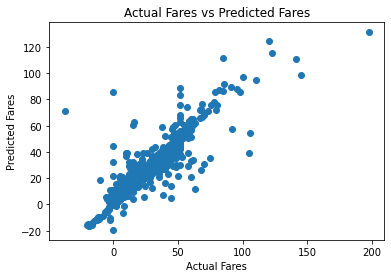

In [50]:
plt.scatter(Y_valid,preds2)
plt.xlabel("Actual Fares")
plt.ylabel("Predicted Fares")
plt.title("Actual Fares vs Predicted Fares")
plt.show()

In [51]:
final_data = pd.read_csv('test_data_iitm.csv')

In [52]:
final_data['fare_amount'] = preds

In [53]:
final_data.to_csv('AE19B051_VARIJA_predictions.csv', index=False)

#### Final comparison

In [58]:
print(f"We get {XGB_valid * 100:0.2f}% accuracy on Validation set for XGBoost ")
print(f"We get {r2score_validation * 100:0.2f}% accuracy on Validation set for Lasso Regression ")

We get 92.09% accuracy on Validation set for XGBoost 
We get 66.81% accuracy on Validation set for Lasso Regression 
